In [8]:
# Importing neccessary packages
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from utils import get_data_generators

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
NUM_CLASSES = 11

In [0]:
classes_list = [
    'Bread',
    'Dairyproduct', 
    'Dessert', 
    'Egg', 
    'Friedfood', 
    'Meat', 
    'NoodlesPasta', 
    'Rice', 
    'Seafood', 
    'Soup', 
    'VegetableFruit'
]

In [13]:
classes_list

['Bread',
 'Dairyproduct',
 'Dessert',
 'Egg',
 'Friedfood',
 'Meat',
 'NoodlesPasta',
 'Rice',
 'Seafood',
 'Soup',
 'VegetableFruit']

In [14]:
classes_list[0]

'Bread'

In [0]:
# Data augmentation for regularization and adding some extra training samples

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input,
    rescale=1.0/255.0,
    horizontal_flip=True, 
    zoom_range=0.2,
    shear_range=0.2
)

In [0]:
TARGET_DIM = 300
BATCH_SIZE = 32

In [29]:
train_generator, validation_generator = get_data_generators(datagen, target_dim = TARGET_DIM)

Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.


In [30]:
train_generator.class_indices

{'Bread': 0,
 'Dairyproduct': 1,
 'Dessert': 2,
 'Egg': 3,
 'Friedfood': 4,
 'Meat': 5,
 'NoodlesPasta': 6,
 'Rice': 7,
 'Seafood': 8,
 'Soup': 9,
 'VegetableFruit': 10}

In [31]:
validation_generator.class_indices

{'Bread': 0,
 'Dairyproduct': 1,
 'Dessert': 2,
 'Egg': 3,
 'Friedfood': 4,
 'Meat': 5,
 'NoodlesPasta': 6,
 'Rice': 7,
 'Seafood': 8,
 'Soup': 9,
 'VegetableFruit': 10}

In [0]:
# Lets try the Resnet152 architecture

base_model = tf.keras.applications.resnet.ResNet152(
    include_top=False, 
    weights='imagenet', 
    input_shape=(TARGET_DIM, TARGET_DIM, 3)
)

In [0]:
base_model.summary()

In [0]:
print('Layers in Resnet152: ' + str(len(base_model.layers)))

Layers in Resnet152: 515


In [0]:
preds = base_model.output
preds = tf.keras.layers.GlobalAveragePooling2D()(preds)
preds = tf.keras.layers.Dense(512, activation=tf.nn.relu)(preds)
preds = tf.keras.layers.BatchNormalization()(preds)
preds = tf.keras.layers.Dense(256, activation=tf.nn.relu)(preds)
preds = tf.keras.layers.BatchNormalization()(preds)
preds = tf.keras.layers.Dense(128, activation=tf.nn.relu)(preds)
preds = tf.keras.layers.Dense(11, activation=tf.nn.softmax)(preds)

In [0]:
model = tf.keras.models.Model(base_model.input, preds)

In [0]:
model.summary()

In [0]:
model.layers[-7].name

'global_average_pooling2d_1'

In [0]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [0]:
# Create directory in drive for storing model
!mkdir drive/My\ Drive/food_11_weights

In [0]:
# Lets define checkpoint for model saving
filepath="./drive/My Drive/food_11_weights/resnet152-2-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [0]:
# Freeze mobilenet layers and train only newly added layers

for layers in model.layers[:-7]:
    layers.trainable = False

for layers in model.layers[-7:]:
    layers.trainable = True

In [0]:
#Let's train the model 20 epochs as it will take a lot of time

model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint],
    epochs=20
)

### Results

Training accuracy: 0.5326<br>
Training loss: 1.3332 <br>

Validation accuracy: 0.52307<br>
Validation loss: 1.4663<br>

Avoidable bias: 0.4674<br>
Variance: 0.00953<br>

Avoidable bias is higher than variance, so model needs to fit on training data.

In [0]:
# Load previous best model
model = tf.keras.models.load_model('./drive/My Drive/food_11_weights/resnet152-20-0.52.hdf5')

In [0]:
# Train the model further for 30 epochs
model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint],
    epochs=30
)

In [0]:
def plot_model_results(num_epochs, history, key):

    plt.plot(range(num_epochs), history[key])
    plt.plot(range(num_epochs), history['val_' + key])
    plt.xlabel('Epochs')
    plt.ylabel(key)
    plt.show()


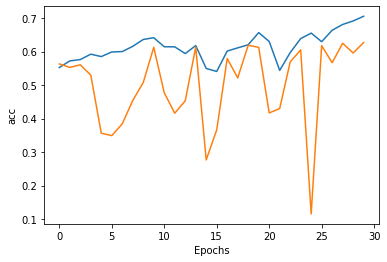

In [0]:
plot_model_results(30, model.history.history, 'acc')

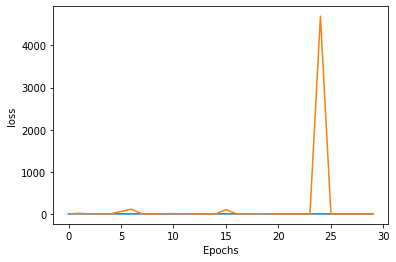

In [0]:
plot_model_results(30, model.history.history, 'loss')

### Results:

Training accuracy: 0.7056<br>
Training loss: 0.8521<br>

Validation accuracy: 0.64734<br>
Validation loss: 1.1362<br>

Avoidable bias: 0.2944 <br>
Variance: 0.05826<br>

Avoidable bias is higher than variance, so model needs to fit on training data.

In [0]:
# Load the previous best model
model = tf.keras.models.load_model('./drive/My Drive/food_11_weights/resnet152-2-01-0.65.hdf5')

In [0]:
## Adding two extra layers for fitting to the training data
preds = model.layers[-6].output
preds = tf.keras.layers.Dense(512, activation=tf.nn.relu)(preds)
preds = model.layers[-5](preds)
preds = model.layers[-4](preds)
preds = model.layers[-3](preds)
preds = model.layers[-2](preds)
preds = tf.keras.layers.Dense(128, activation=tf.nn.relu)(preds)
preds = model.layers[-1](preds)
model = tf.keras.models.Model(model.input, preds)

In [0]:
for layers in model.layers[:-9]:
    layers.trainable = False

for layers in model.layers[-9:]:
    layers.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [0]:
model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint],
    epochs=10
)

### Results:

Training accuracy: 0.7655<br>
Training loss: 0.6918 <br>

Validation accuracy: 0.57710<br>
Validation loss: 1.4075<br>

Avoidable bias: 0.2345 <br>
Variance: 0.1884 <br>

By adding two extra dense layers, the model is fitting to the training data so avoidable bias is decreasing but variance is increasing.<br></br>

Here avoidable bias is still higher than variance, so model needs to further train on training data.